# Классификация текстов с использованием Наивного Байесовского Классификатора

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score

import matplotlib.pyplot as plt


## Задание 1 (1 балл)

Откройте данные. Узнайте, сколько в них спам- и не спам-писем. Визуализируйте полученные соотношение подходящим образом.

In [2]:
# откройте данные:
df = pd.read_csv('spam_or_not_spam.zip', compression='zip')
df.head(5)

,email,label
0,date wed NUMBER aug NUMBER NUMBER NUMBER NUMB...,0
1,martin a posted tassos papadopoulos the greek ...,0
2,man threatens explosion in moscow thursday aug...,0
3,klez the virus that won t die already the most...,0
4,in adding cream to spaghetti carbonara which ...,0


In [3]:
# рассчитайте частоты для классов : 
class_frequencies = df['label'].value_counts(normalize=True)
class_counts = df['label'].value_counts()

print(f'Распределение классов относительное: {class_frequencies}\n')
print(f'Распределение классов количественное: {class_counts}')

Распределение классов относительное: label
0    0.833333
1    0.166667
Name: proportion, dtype: float64

Распределение классов количественное: label
0    2500
1     500
Name: count, dtype: int64


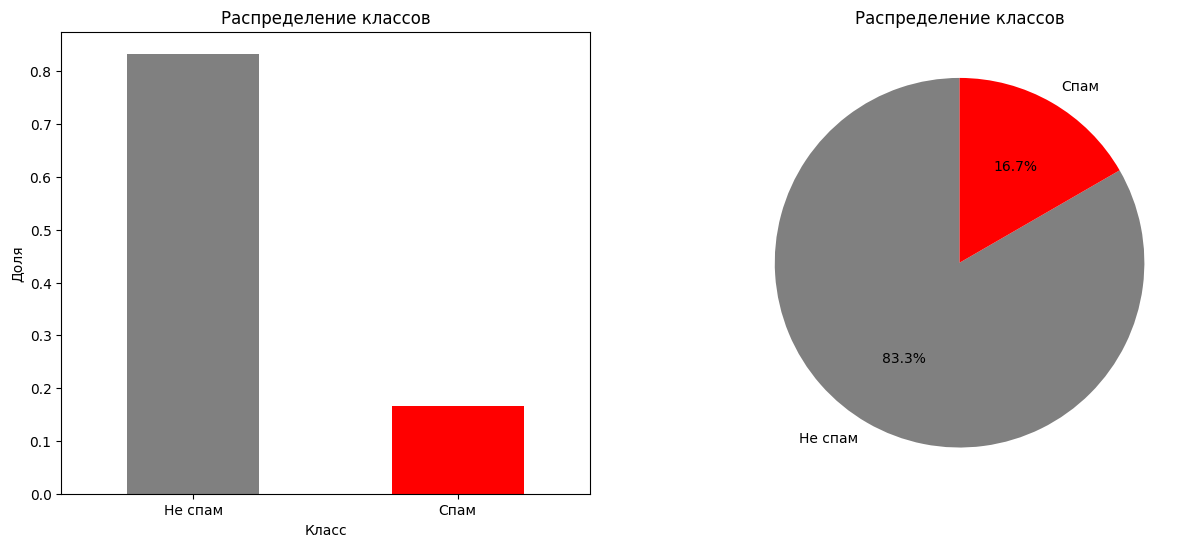

In [ ]:
# визуализируйте результат: 
class_frequencies.index = ['Не спам', 'Спам']

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

class_frequencies.plot(kind='bar', color=['grey', 'red'], ax=axes[0])
axes[0].set_title('Распределение классов')
axes[0].set_xlabel('Класс')
axes[0].set_ylabel('Доля')
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['Не спам', 'Спам'], rotation=0)

class_frequencies.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['grey', 'red'], ax=axes[1])
axes[1].set_title('Распределение классов')
axes[1].set_ylabel('')  

plt.show()

## Задание 2 (2 балла)

Вам необходимо предобработать ваши данные и перевести их в векторный вид.

Замените в данных все пустые строки и строки, состоящие из пробелов, на пропуски (NaN). После этого удалите из данных все строки, в которых наблюдаются пропущенные значения.

In [5]:
df['email'] = df['email'].apply(lambda x: np.nan if isinstance(x, str) and x.strip() == '' else x)
df['email'] = df['email'].str.lower()
df_cleaned = df.dropna()

print('Число строк до очистки:', len(df))
print('Число строк после очистки:', len(df_cleaned))

Число строк до очистки: 3000
Число строк после очистки: 2997


Переводим данные в векторный вид:

In [6]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df_cleaned['email'])

Определите, сколько теперь признаков в нашем наборе данных:

In [7]:
num_features = X.shape[1]

print(f'Количество признаков в наборе данных: {num_features}')

Количество признаков в наборе данных: 34116


## Задание 3 (2 балла)

Определите целевую переменную и признаки:

In [8]:
y = df_cleaned['label']

print(f'Размер целевой переменной: {y.shape}')
print(f'Размер матрицы признаков: {X.shape}')

Размер целевой переменной: (2997,)
Размер матрицы признаков: (2997, 34116)


Разделите выборку на обучающую и тестовую, используя стратифицированное разбиение (параметр `stratify` установите в значение вектора ответов y) размер тестовой выборки (`test_size`) возьмите как 0.25, параметр `random_state` определите со значением 42:

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

print(f'Размер обучающей выборки: {X_train.shape[0]}')
print(f'Размер тестовой выборки: {X_test.shape[0]}')

Размер обучающей выборки: 2247
Размер тестовой выборки: 750


Рассчитайте среднее значение целевой переменной по тестовой выборке:

In [10]:
mean_target_value = y_test.mean()

print(f'Среднее значение целевой переменной по тестовой выборке: {mean_target_value:.3f}')

Среднее значение целевой переменной по тестовой выборке: 0.165


## Задание 4 (3 балла)

Определите и обучите подходящий алгоритм с параметром alpha = 0.01

In [11]:
model = MultinomialNB(alpha=0.01)
model.fit(X_train, y_train)

# Оценка точности модели на тестовой выборке
accuracy = model.score(X_test, y_test)

print(f'Точность модели на тестовой выборке: {accuracy:.3f}')

Точность модели на тестовой выборке: 0.987


Оцените результат с точки зрения всех известных вам метрик (не менее трёх):

In [12]:
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Точность (Accuracy): {accuracy:.3f}')
print(f'Точность (Precision): {precision:.3f}')
print(f'Полнота (Recall): {recall:.3f}')
print(f'F1-мера: {f1:.3f}')

Точность (Accuracy): 0.987
Точность (Precision): 1.000
Полнота (Recall): 0.919
F1-мера: 0.958


Нарисуйте ROC-кривую:

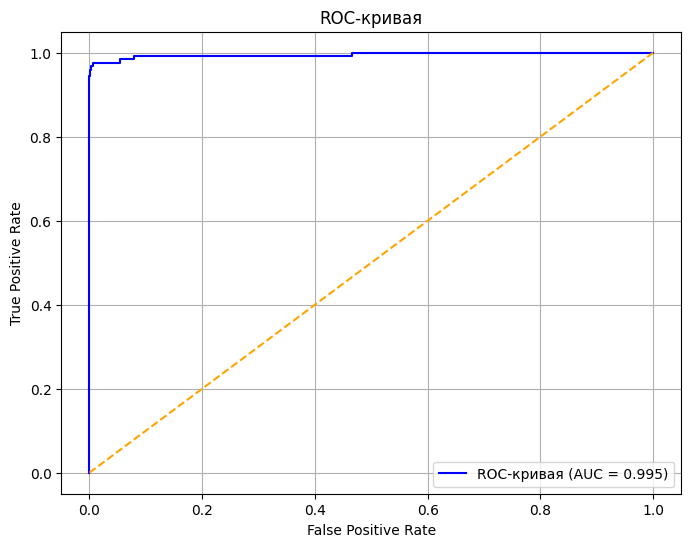

In [13]:
# Предсказания вероятностей для класса 1 (Спам)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Вычисление ROC-кривой и AUC-чтобы получить числовое значение качества модели
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

# Построение ROC-кривой
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC-кривая (AUC = {auc:.3f})')
plt.plot([0, 1], [0, 1], color='orange', linestyle='--')
plt.title('ROC-кривая')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## Задание 5 (3 балла)

Переберите несколько значений alpha с помощью кросс-валидации. Оцените, зависит ли от этого параметра качество классификации.

In [14]:
alpha_values = [0.001, 0.01, 0.1, 1, 10]

model = MultinomialNB()

param_grid = {'alpha': alpha_values}
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_alpha = grid_search.best_params_['alpha']
best_accuracy = grid_search.best_score_

print(f'Наилучшее значение alpha: {best_alpha}')
print(f'Точность модели при наилучшем значении alpha: {best_accuracy:.3f}')

Наилучшее значение alpha: 0.1
Точность модели при наилучшем значении alpha: 0.992


Вывод: Изменение параметра alpha привело к улучшению значения модели с 0.987 до 0.992.

Модель качественная, сильная.